In [2]:
from __future__ import unicode_literals
import warnings
import spacy
from spacy import displacy
import textacy
import re
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from sklearn.cluster import KMeans
from sklearn.decomposition.truncated_svd import TruncatedSVD


nlp = spacy.load('en_core_web_lg')

In [ ]:
%matplotlib inline 

#### Loading both documents

In [3]:
with open('cv.txt') as f:
    resume = f.read()
    
with open('requirement.txt',encoding='utf-8') as f:
    req = f.read()


#### Some preprocessing ( here i get all the newline caracters \n and replace them by . )

In [4]:
def preprocess(txt):
    txt=re.sub(r'^\s*$','', txt)
    return".".join([re.sub('[^.,a-zA-Z ]', '', i.strip()) for  i in txt.split("\n")])

In [5]:
req=preprocess(req)

In [6]:
resume=preprocess(resume)

In [7]:
print(req)

 Sample text.. Roles.. Role . Understand customer needs and develop highquality presentations, proposals and software demonstrations that speak to these needs  building a consensus for change on a multistakeholder basis. Work with the Enterprise sales team to build, manage and maintain customer relationships. Provide presales technical assistance to members of the sales team to ensure proper technical and business fit. Work with marketing on new product development. Present professional and personalised demos. Need to ensure prospective customers are aligned technically with the sales process. Need to understand and demonstrate the solution and how to integrate to other business systems.. Role ..Must Have.. Experience shaping the BI strategy from CLevel to Technical developers.. Extensive delivery of platform within a Business Intelligence and Analytics function.. Communication with stakeholders on all levels.. Understanding and experience within KPIs, identifying data sources, buildin

###### Here a code to implement to parse sentences by \n and add it to spacy pipeline before parser ( i didn't use it here )

In [119]:
#  def set_custom_boundaries(doc):
#     for token in doc[:-1]:
#         if token.text == '\n':
#             doc[token.i+1].is_sent_start = True
#     return doc

# nlp.add_pipe(set_custom_boundaries, before='parser')
# nlp.pipe_names

#### Creating the spacy doc object and geting sentences 

In [8]:
doc0=nlp(req) 

In [9]:
sentences=[sent for sent in doc0.sents]

### The function bellow will detect if a sentence is nominal or verbal and split it into sub phrases. I used textacy library to use part of speech regex. 

In [14]:
def phrase_patterns(doc,doc_sent= True):
    if(doc_sent):
        #doc_sent : apply the function through an list of sentences (itterable)
        
        #Verbal phrase pos patern
        pattern1 = r'<VERB><PART>?<PUNCT>?<VERB>?<CCONJ>?<VERB>?(<ADV>?<ADJ>?<PUNCT>?<CCONJ>?<DET>?<ADP>?<PROPN>?<NOUN>*)+<NOUN>+'
         #Noun Phrase pos pattern
        pattern2= r'^<NOUN>+<CCONJ>?<PART>?<DET>?<NOUN>?<ADP>?<VERB>?<NUM>?(<CCONJ>?<ADJ>?<PUNCT>?<DET>?<ADP>?<NOUN>?<PROPN>?)+'
        
        #pattern2= r'(<ADJ>?<PUNCT>?<DET>?<ADP>?<VERB>?)+<NOUN>+<CCONJ>?<NOUN>?<VERB>?(<CCONJ>?<ADJ>?<PUNCT>?<DET>?<ADP>?<NOUN>?<PROPN>?)+'
        #pattern3= r'(<PRON>?<VERB>?<ADJ>?)<NOUN>+<CCONJ>?<NOUN>?<VERB>?(<CCONJ>?<ADJ>?<PUNCT>?<DET>?<ADP>?<NOUN>?<PROPN>?)+'
        
       
        #lambda expression to choose the suitable pattern 
        pat= lambda sent : pattern1 if(sent[0].pos_ =='VERB') else pattern2

        a=[lis2 for lis in [textacy.extract.pos_regex_matches(sent, pat(sent)) for sent in doc.sents] for lis2 in lis]  

        #The lines bellow applly the verb- noun decomp to nominal phrases ... ( this approach do not generalize well )
#         b=[list2 for lis in [textacy.extract.pos_regex_matches(sent, pattern2) 
#                                 for lis in [textacy.extract.pos_regex_matches(sent, pattern) for sent in doc.sents] 
#                                         for sent in lis] 
#                                                     for list2 in lis ]
        #b=[lis2 for lis in [textacy.extract.pos_regex_matches(sent, pat(sent)) for sent in doc.sents] for lis2 in lis] 

    else:
        
        a=[lis for lis in textacy.extract.pos_regex_matches(doc, pattern)]  

#         b=[list2 for lis in [textacy.extract.pos_regex_matches(doc, pattern2) 
#                                 for lis in textacy.extract.pos_regex_matches(doc, pattern)
#                                         ] 
#                                                     for list2 in lis ]

        #b=[lis for lis in textacy.extract.pos_regex_matches(doc, pattern3)]  

    return list(set(a))


#### Example of dependency graph for a sentence

In [15]:
sentences[8]
displacy.render(sentences[-1], style='dep', jupyter=True)



#### Let's apply our function to the document and get the component phrases 

In [16]:
phrases=[i for i in phrase_patterns(doc0) if len(i)>3]

In [17]:
phrases

[Define, guide and implement innovation programs,
 Collaborate with other AWS specialist teams,
 Enhance and build digital transformation roadmaps,
 speak to these needs,
 develop highquality presentations, proposals and software demonstrations,
 Experience implementing one or more enterprise solutions on premise andor in the cloud ERP, PLM, IoT,
 Establish the use of cloud services,
 Led and built a Business Intelligence function and team,
 IT architectures, executive agenda items and metrics..,
 Experience in two or more of the following transformation practice areas ERP business process architecture and solution implementation, business case and,
 Need to ensure prospective customers,
 building a consensus for change on a multistakeholder basis,
 Experience with a major consulting firm or experience in a corporate role,
 Develop Csuite and lineofbusiness relationships within the customer organization,
 Link digital capabilities to our clients business strategy,
 Work with marketing 

#### let's display our phrases and apply a second layer of preprocessing 

In [18]:
def preprocess2 (txt):
    txt = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", txt)
    txt = txt.lower()
    txt = re.sub(r"\W"," ",txt)
    txt = re.sub(r"\d"," ",txt)
    txt = re.sub(r"\s+[a-z]\s+"," ",txt)
    txt = re.sub(r"\s+[a-z]$"," ",txt)
    txt = re.sub(r"^[a-z]\s+"," ",txt)
    txt = re.sub(r"\s+"," ",txt)

    return txt

In [19]:
doc1df=pd.DataFrame([i.text for i in phrases],columns=['output'])
doc1df['output']=doc1df['output'].apply(lambda txt: preprocess2(txt))
doc1df

,output
0,define guide and implement innovation programs
1,collaborate with other aws specialist teams
2,enhance and build digital transformation roadmaps
3,speak to these needs
4,develop highquality presentations proposals an...
5,experience implementing one or more enterprise...
6,establish the use of cloud services
7,led and built business intelligence function a...
8,it architectures executive agenda items and me...
9,experience in two or more of the following tra...


### Let's compute the similarity matrix for the document 

In [20]:
## here i'm doing a cartesian product of phrases column with each other and the compute the similarity matrix 
## cartesian pruduct : 
def product(*args):
    if not args:
        return iter(((),)) # yield tuple()
    return (items + (item,) 
            for items in product(*args[:-1]) for item in args[-1])

##list of phrase tuples 

mat_doc1=list(product(doc1df['output'], doc1df['output']))

## Compute the similarity of phrase tuples using spacy semantic similarity

result=list(map(lambda doc : nlp(doc[0]).similarity(nlp(doc[1])), mat_doc1))

Matrix_doc1=np.array(result).reshape((len(doc1df['output']),-1))

In [21]:
## let's shape the result as a square matrix

Matrix_doc1=np.array(result).reshape((len(doc1df['output']),-1))

In [83]:
## let's display the matrix as a dataframe
pd.DataFrame(Matrix_doc1,columns= [f"Phrase {i}" for i in range(len(phrases)) ])

,Phrase 0,Phrase 1,Phrase 2,Phrase 3,Phrase 4,Phrase 5,Phrase 6,Phrase 7,Phrase 8,Phrase 9,...,Phrase 20,Phrase 21,Phrase 22,Phrase 23,Phrase 24,Phrase 25,Phrase 26,Phrase 27,Phrase 28,Phrase 29
0,1.000000,0.668444,0.795344,0.707510,0.751254,0.753275,0.780562,0.751601,0.797926,0.817803,...,0.788535,0.605997,0.743018,0.772752,0.755169,0.745828,0.751301,0.746631,0.790300,0.776877
1,0.668444,1.000000,0.581431,0.662069,0.629400,0.669252,0.687386,0.733817,0.633733,0.707874,...,0.689815,0.499512,0.746658,0.671469,0.644251,0.597697,0.664609,0.640311,0.654326,0.709337
2,0.795344,0.581431,1.000000,0.620564,0.741842,0.709302,0.705130,0.727697,0.746976,0.760925,...,0.721235,0.605434,0.640604,0.783183,0.740434,0.756792,0.703700,0.723696,0.723345,0.742168
3,0.707510,0.662069,0.620564,1.000000,0.593234,0.633995,0.731632,0.708881,0.703581,0.757868,...,0.782766,0.571162,0.756646,0.737251,0.690681,0.701740,0.719219,0.695741,0.892396,0.761768
4,0.751254,0.629400,0.741842,0.593234,1.000000,0.680828,0.640103,0.645032,0.689396,0.712107,...,0.678980,0.530299,0.680850,0.685669,0.654994,0.633744,0.637717,0.685150,0.662193,0.700722
5,0.753275,0.669252,0.709302,0.633995,0.680828,1.000000,0.806161,0.696036,0.742988,0.870502,...,0.724337,0.623710,0.695769,0.789741,0.762464,0.722084,0.733695,0.758223,0.749765,0.759001
6,0.780562,0.687386,0.705130,0.731632,0.640103,0.806161,1.000000,0.764407,0.736875,0.865682,...,0.774076,0.681756,0.804723,0.876995,0.848624,0.732291,0.780783,0.749619,0.833539,0.782729
7,0.751601,0.733817,0.727697,0.708881,0.645032,0.696036,0.764407,1.000000,0.776217,0.844631,...,0.799065,0.636563,0.782170,0.806569,0.778722,0.768440,0.765226,0.702083,0.769797,0.798114
8,0.797926,0.633733,0.746976,0.703581,0.689396,0.742988,0.736875,0.776217,1.000000,0.805069,...,0.768227,0.618019,0.719410,0.767015,0.759692,0.717590,0.770578,0.729521,0.734625,0.783557
9,0.817803,0.707874,0.760925,0.757868,0.712107,0.870502,0.865682,0.844631,0.805069,1.000000,...,0.844619,0.701513,0.810440,0.893794,0.847400,0.810715,0.855928,0.790792,0.857709,0.852706


## Second file 

#### The same steps 

In [23]:
doc1=nlp(resume)

In [24]:
phrases1=[i for i in phrase_patterns(doc1) if len(i)>3]

In [25]:
phrases1

[Solution lead, Company,
 Project lead, Company,
 Programme lead, Company,
 Delivered a Proof of Value PoV,
 Mapped and optimised process,
 establish the automation solution,
 Project moved into implementation,
 Solution lead and architect, Company,
 Delivered an automation ecosystem,
 leading to significant business benefits and cost savings,
 Turned project around after initial process assessment,
 spent in finance processes,
 delivered the automation solution,
 Identified processes automation portfolio,
 Solution lead and HR workstream lead, Company,
 Went through a complex architecture and governance process,
 Business case showed an RoI of,
 Business case demonstrated savings of,
 Defined a scalable architecture,
 Project and solution lead, Company,
 built capability with the customer,
 given a very demanding customer,
 Developed demand generation and assessment approach,
 moved into second implementation wave]

In [26]:
doc2df=pd.DataFrame([i.text for i in phrases1],columns=['output'])
doc2df['output']=doc2df['output'].apply(lambda txt: preprocess2(txt))
doc2df

,output
0,solution lead company
1,project lead company
2,programme lead company
3,delivered proof of value pov
4,mapped and optimised process
5,establish the automation solution
6,project moved into implementation
7,solution lead and architect company
8,delivered an automation ecosystem
9,leading to significant business benefits and c...


### Now let's compute the sililarity matrix between the 2 documents phrases ( it's not a square matrix) 

In [27]:
mat_doc2=list(product(doc2df['output'], doc1df['output']))
result1=list(map(lambda doc : nlp(doc[0]).similarity(nlp(doc[1])), mat_doc2))
Matrix_doc2=np.array(result1).reshape((len(doc2df['output']),-1))

#### <center> The columns labels are phrases from the first document </center>
<table>
  <tr>
    <th></th>
    <th>Phrase1 Doc0</th>
    <th>Phrase2 Doc0</th>
    <th>Phrase3 Doc0</th>
  </tr>
  <tr>
    <td>Phrase1 Doc1</td>
    <td>similarity(p1,p1)</td>
    <td>similarity(p1,p2)</td>
    <td>similarity(p1,p3)</td>
  </tr>
  <tr>
    <td>Phrase1 Doc1</td>
    <td></td>
    <td></td>
    <td></td>
  </tr>
  <tr>
    <td>Phrase1 Doc1</td>
    <td></td>
    <td></td>
    <td></td>
  </tr>
</table>

In [28]:
sim_doc1_doc2=pd.DataFrame(Matrix_doc2,columns= [f"Phrase {i}" for i in range(len(phrases)) ]) 
sim_doc1_doc2['average_similarity']=sim_doc1_doc2.mean(numeric_only=True, axis=1)
sim_doc1_doc2.head()

,Phrase 0,Phrase 1,Phrase 2,Phrase 3,Phrase 4,Phrase 5,Phrase 6,Phrase 7,Phrase 8,Phrase 9,...,Phrase 21,Phrase 22,Phrase 23,Phrase 24,Phrase 25,Phrase 26,Phrase 27,Phrase 28,Phrase 29,average_similarity
0,0.622146,0.637835,0.623295,0.613540,0.563299,0.746068,0.730672,0.729882,0.635397,0.770882,...,0.607294,0.710913,0.817346,0.667493,0.721233,0.724162,0.708655,0.748605,0.640388,0.693502
1,0.638348,0.658662,0.626288,0.602970,0.585774,0.667789,0.684199,0.750725,0.651111,0.731276,...,0.615264,0.740103,0.770869,0.643584,0.604522,0.718467,0.663493,0.652267,0.644045,0.678317
2,0.648358,0.641283,0.587502,0.571371,0.605792,0.625142,0.660128,0.726411,0.632645,0.705046,...,0.567730,0.724048,0.741847,0.622494,0.592519,0.686629,0.676124,0.627810,0.656219,0.658867
3,0.528824,0.423733,0.515106,0.605257,0.466503,0.595678,0.661724,0.601443,0.608946,0.674869,...,0.547541,0.612187,0.691981,0.721142,0.597869,0.639513,0.563066,0.664148,0.643291,0.598563
4,0.680096,0.530600,0.704941,0.539639,0.595341,0.610749,0.629912,0.636701,0.672429,0.711611,...,0.550857,0.568177,0.650836,0.614782,0.667125,0.746009,0.605433,0.648688,0.677516,0.627325


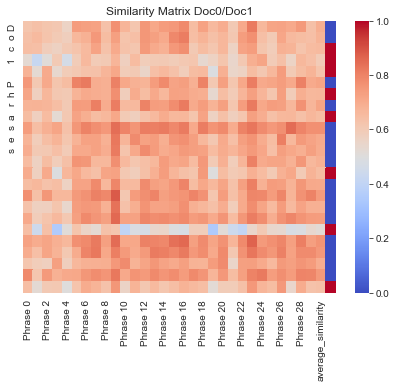

In [114]:
plt.figure(figsize=(7,5))
sns.heatmap(sim_doc1_doc2,yticklabels="Doc1 Phrases",cmap='coolwarm')
plt.title("Similarity Matrix Doc0/Doc1")
plt.show()

<b>We notice above that phrase 4 from resume document (doc0) has a big average similarity with the phrases of document 0 
let's explore this phrase</b>

In [29]:
sim_doc1_doc2["average_similarity"].idxmax()

9

In [30]:
phrases1[1]

Project lead, Company

#### let's now display the most similar phrase from the requirement document (doc0) 


In [31]:
phrases[int(sim_doc1_doc2.iloc[1].idxmax().split()[1])]

Work with the Enterprise sales team

#### Let's do some small exploratory analysis

In [33]:
sim_doc1_doc2.describe()

,Phrase 0,Phrase 1,Phrase 2,Phrase 3,Phrase 4,Phrase 5,Phrase 6,Phrase 7,Phrase 8,Phrase 9,...,Phrase 21,Phrase 22,Phrase 23,Phrase 24,Phrase 25,Phrase 26,Phrase 27,Phrase 28,Phrase 29,average_similarity
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,...,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,0.678445,0.596922,0.653288,0.617832,0.601408,0.702602,0.721155,0.719392,0.687876,0.778360,...,0.606725,0.692156,0.764637,0.705614,0.676900,0.731980,0.678099,0.716756,0.697194,0.688859
std,0.056990,0.066684,0.058914,0.081115,0.055897,0.055960,0.061545,0.074745,0.045159,0.064901,...,0.053222,0.084155,0.069912,0.057822,0.063659,0.059468,0.078673,0.077574,0.060635,0.057341
min,0.528824,0.423733,0.515106,0.353879,0.466503,0.595678,0.560287,0.529211,0.608946,0.618566,...,0.439231,0.406657,0.547751,0.605962,0.546467,0.535165,0.478634,0.492127,0.539725,0.520703
25%,0.647166,0.576562,0.620672,0.599700,0.580566,0.667008,0.684136,0.674340,0.662842,0.730533,...,0.588269,0.663776,0.734862,0.671179,0.634731,0.721025,0.663050,0.661177,0.664173,0.657209
50%,0.677311,0.600980,0.647344,0.623890,0.607728,0.713297,0.727686,0.729216,0.688326,0.785435,...,0.610416,0.714978,0.774143,0.704248,0.664384,0.738858,0.679847,0.748241,0.685781,0.696021
75%,0.710856,0.641330,0.704806,0.668930,0.636157,0.743445,0.759412,0.775427,0.715848,0.825991,...,0.640173,0.736439,0.814365,0.727784,0.739955,0.768578,0.717802,0.767763,0.737938,0.725487
max,0.787220,0.700174,0.756295,0.732445,0.708960,0.802444,0.822251,0.828034,0.791238,0.886197,...,0.699786,0.802227,0.869034,0.823955,0.771614,0.811931,0.848514,0.809708,0.801546,0.770255


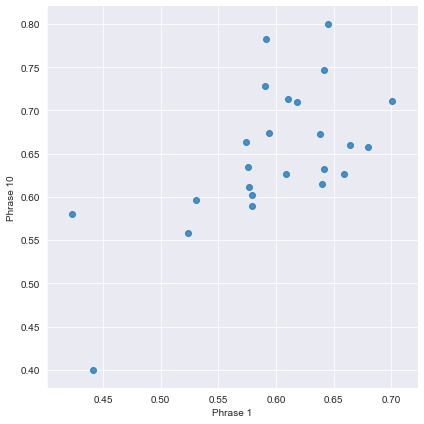

In [34]:
sns.set_style('darkgrid')
# Phrase 1 to 33 are all in document0 ( requirements) 
sns.lmplot("Phrase 1","Phrase 10",data=sim_doc1_doc2,height=6,aspect=1,fit_reg=False)

#### Lets plot some histograms to see the variation of similarity for the phrases across the document

C:\Users\amine\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


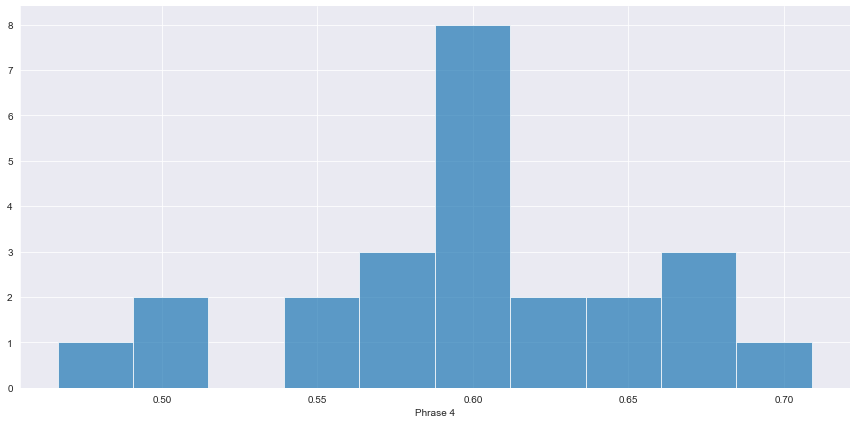

In [35]:
sns.set_style('darkgrid')
g = sns.FacetGrid(sim_doc1_doc2,palette='coolwarm',size=6,aspect=2)
g = g.map(plt.hist,"Phrase 4",alpha=0.7)

### Let's now find the similarity buckets 

#### We used Kmeans clustering to clusters document phrases 
##### We choose  2 clusters

In [37]:
kmeans = KMeans(n_clusters=2)

In [38]:
kmeans.fit(Matrix_doc2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [39]:
## bucket centers
kmeans.cluster_centers_

array([[0.69124211, 0.62683795, 0.66229689, 0.6568936 , 0.61620918,
        0.72911038, 0.75206184, 0.75689026, 0.70343127, 0.81256846,
        0.6890469 , 0.6976743 , 0.75636358, 0.75544919, 0.74880546,
        0.75919501, 0.78051633, 0.71003478, 0.73814926, 0.66943067,
        0.73255069, 0.62953922, 0.73458931, 0.80091781, 0.72969397,
        0.70791178, 0.75759333, 0.71378297, 0.75814532, 0.72275491],
       [0.65285005, 0.53709041, 0.63526961, 0.53971   , 0.57180595,
        0.64958651, 0.65934228, 0.64439412, 0.65676434, 0.70994262,
        0.57123911, 0.61508404, 0.61324507, 0.65155706, 0.65480697,
        0.64936691, 0.64652199, 0.63397913, 0.65604348, 0.52000534,
        0.62898507, 0.56109614, 0.6072907 , 0.69207598, 0.65745397,
        0.61487673, 0.68075243, 0.60672974, 0.63397688, 0.64607235]])

In [40]:
## cluster labels for each phrase of document 1
kmeans.labels_

array([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1])

In [41]:
sim_doc1_doc2['Clusters']=kmeans.labels_


In [42]:
sim_doc1_doc2.head(8)

,Phrase 0,Phrase 1,Phrase 2,Phrase 3,Phrase 4,Phrase 5,Phrase 6,Phrase 7,Phrase 8,Phrase 9,...,Phrase 22,Phrase 23,Phrase 24,Phrase 25,Phrase 26,Phrase 27,Phrase 28,Phrase 29,average_similarity,Clusters
0,0.622146,0.637835,0.623295,0.613540,0.563299,0.746068,0.730672,0.729882,0.635397,0.770882,...,0.710913,0.817346,0.667493,0.721233,0.724162,0.708655,0.748605,0.640388,0.693502,0
1,0.638348,0.658662,0.626288,0.602970,0.585774,0.667789,0.684199,0.750725,0.651111,0.731276,...,0.740103,0.770869,0.643584,0.604522,0.718467,0.663493,0.652267,0.644045,0.678317,0
2,0.648358,0.641283,0.587502,0.571371,0.605792,0.625142,0.660128,0.726411,0.632645,0.705046,...,0.724048,0.741847,0.622494,0.592519,0.686629,0.676124,0.627810,0.656219,0.658867,1
3,0.528824,0.423733,0.515106,0.605257,0.466503,0.595678,0.661724,0.601443,0.608946,0.674869,...,0.612187,0.691981,0.721142,0.597869,0.639513,0.563066,0.664148,0.643291,0.598563,1
4,0.680096,0.530600,0.704941,0.539639,0.595341,0.610749,0.629912,0.636701,0.672429,0.711611,...,0.568177,0.650836,0.614782,0.667125,0.746009,0.605433,0.648688,0.677516,0.627325,1
5,0.753113,0.610705,0.709652,0.623679,0.651801,0.802444,0.822251,0.695801,0.690560,0.805633,...,0.714248,0.814017,0.708304,0.722316,0.739742,0.710259,0.806315,0.706751,0.720191,0
6,0.721988,0.579390,0.670204,0.616195,0.608408,0.676626,0.706438,0.697940,0.689170,0.774079,...,0.671916,0.734017,0.673310,0.620151,0.734823,0.597218,0.692399,0.666824,0.669211,1
7,0.677481,0.679902,0.674615,0.645611,0.607049,0.742571,0.739123,0.810419,0.699266,0.813254,...,0.738964,0.824152,0.712547,0.739766,0.731137,0.671480,0.768376,0.675723,0.720944,0


In [43]:
sim_doc1_doc2['Clusters']

0     0
1     0
2     1
3     1
4     1
5     0
6     1
7     0
8     1
9     0
10    0
11    0
12    0
13    1
14    0
15    0
16    0
17    0
18    1
19    0
20    0
21    0
22    0
23    1
Name: Clusters, dtype: int32

#### Let's see with a plot if we can see the clusters 

##### Cluster 0 represent's the phrases that are similar between the 2 documents
##### Cluster 1 represent's the phrases that are in document 2 but not in document 1

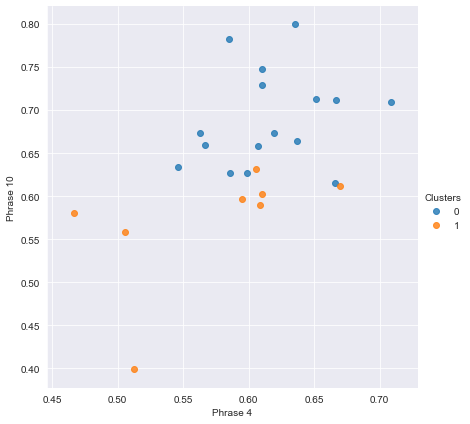

In [44]:
sns.set_style('darkgrid')
# Phrase 1 to 33 are all in document0 ( requirements) 
sns.lmplot("Phrase 4","Phrase 10",hue='Clusters',data=sim_doc1_doc2,height=6,aspect=1,fit_reg=False)

#### lets take the mean of cluster vectors and find bucket centers for each cluster 

In [76]:
bucket_centers=sorted(list(map(np.mean,kmeans.cluster_centers_)))

bucket_centers=pd.DataFrame(np.array(bucket_centers).reshape(1,-1),columns=['Bucket1','Bucket2'],index=['Bucket similarity centers'])
bucket_centers

,Bucket1,Bucket2
Bucket similarity centers,0.626597,0.71999


In [99]:
bucket_centers.iloc[0].median()+ 0.10*bucket_centers["Bucket2"]

Bucket similarity centers    0.745292
Name: Bucket2, dtype: float64

####  We can take the bucket median +10%*bucket2_center as a cuttof point for similarity ( sim(p1_doc0,p2_doc1) > 0.74 => phrases are similar  otherwise phrase belongs to doc0)

In [98]:
sim_doc1_doc2['Phrase 23'].mean()

0.7646372018980246

In [100]:
phrases[23]

Lead customers in the creation of new digital solutions which

In [52]:
## doc0
print(phrases[9])
## doc1
print(phrases1[7])
print(f"similarity score {sim_doc1_doc2.iloc[7][9]}")
print(f"Bucket number {sim_doc1_doc2.Clusters[1]}")

Experience in two or more of the following transformation practice areas ERP business process architecture and solution implementation, business case and
Solution lead and architect, Company
similarity score 0.8132537415009979
Bucket number 0


In [202]:
## doc0
print(phrases[3])
## doc1
print(phrases1[7])
print(f"similarity score {sim_doc1_doc2.iloc[7][3]}")
print(f"Bucket number {sim_doc1_doc2.Clusters[7]}")

Establish the use of cloud services
establish the automation solution
similarity score 0.8222512065571124
Bucket number 0


In [206]:
## doc0
print(phrases[29])
## doc1
print(phrases1[2])
print(f"similarity score {sim_doc1_doc2.iloc[2][29]}")
print(f"Bucket number {sim_doc1_doc2.Clusters[2]}")

Need to understand and demonstrate the solution
Mapped and optimised process
similarity score 0.6486876491675406
Bucket number 1


### Let's now do some dimentionality reduction (singular value decomposition) to see in 2D the doc0 Phrases context similarity

In [54]:
sim_nd=TruncatedSVD()
sim_nd.fit(sim_doc1_doc2.loc[:,:f"Phrase {len(phrases)-1}"])

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
             random_state=None, tol=0.0)

In [55]:
sim_nd.transform

<bound method TruncatedSVD.transform of TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5,
             random_state=None, tol=0.0)>

In [56]:
sim_nd=sim_nd.components_

C:\Users\amine\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


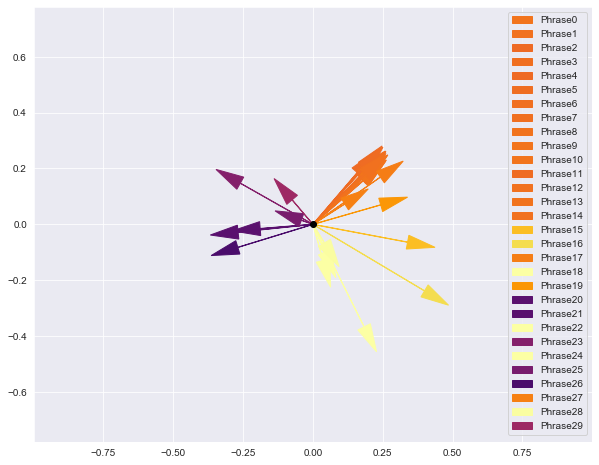

In [70]:
colormap = cm.inferno # colormap used to plot arrows in the same direction 

plt.figure(figsize=(10,8))

M = sim_nd.reshape(-1,2) # Similarity matrix 

rows,cols = M.T.shape

#Get absolute maxes for axis ranges to center origin
#This is optional

maxes = 2.5*np.amax(abs(M), axis = 0)

arrow=[]
for i,l in enumerate(range(0,cols)):
    a=plt.axes().arrow(0,0,M[i,0],M[i,1],head_width=0.05,head_length=0.1,color = colormap(norm(np.arctan2(M[i,0], M[i,1]))),label=f"Phrase{i}")
    arrow.append(a)
plt.plot(0,0,'ok') #<-- plot a black point at the origin
plt.axis('equal')  #<-- set the axes to the same scale
plt.xlim([-maxes[0],maxes[0]]) #<-- set the x axis limits
plt.ylim([-maxes[1],maxes[1]]) #<-- set the y axis limits
plt.grid(b=True, which='major') #<-- plot grid lines
plt.legend(handles=arrow)
plt.show()

<b> As we can see above in the graph phrases 18,22,24 and 28 are sin the same quadrant let's display those phrases </b>

In [73]:
print(phrases[18])
print(phrases[22])
print(phrases[24])
print(phrases[28])

integrate to other business systems
Provide presales technical assistance to members of the sales team
Understanding of modern cloud delivery models Public, Private and Hybrid..
Need to understand and demonstrate the solution


In [74]:
print(phrases[20])
print(phrases[21])
print(phrases[26])
print(phrases[29])

ensure proper technical and business fit
Background within Utilities, Energy, Oil
aligned technically with the sales process
Communication with stakeholders on all levels.. Understanding and experience within KPIs,


***************************************************************************************************************************

















In [183]:
##### Cluster 2 represent's the phrases that are partially similar

In [209]:

#doc=nlp(U'Experience with a major consulting firm or experience in a corporate role delivering strategy and operations projects with an emphasis in business transformation at the intersection of new operating models and new digital technologies.')
# doc=nlp(U'Went through a complex architecture and governance process to establish the automation solution based on UiPath with IT and internal controls')
# doc3=nlp(U'Understand customer needs and develop high-quality presentations, proposals and software demonstrations that speak to these needs – building a consensus for change on a multi-stakeholder basis')
# doc4=nlp(U'Understand customer needs and develop high-quality presentations, proposals and software demonstrations that')
doc5=nlp(U'Experience in two or more of the following transformation practice areas ERP business process architecture and solution implementation, business case and use case development, financial modelling, BI and Analytics strategy and implementation, complex program management, enterprise business process IT architectures, executive agenda items and metrics.')

#doc=nlp(U'Provide pre sales technical assistance to members of the sales team to ensure proper technical and business fit')

      


pattern = r'<VERB>(<ADJ>?<NOUN>*<PUNCT>?<CCONJ>?<NUM>?<DET>?<ADP>?<PROPN>?)+'
pattern2= r'(<ADJ>?<PUNCT>?<DET>?<ADP>?<VERB>?)+<NOUN>+<CCONJ>?<NOUN>?<VERB>?(<CCONJ>?<ADJ>?<PUNCT>?<DET>?<ADP>?<NOUN>?<PROPN>?)+'
pattern3= r'(<PRON>?<VERB>?<ADJ>?)<NOUN>+<CCONJ>?<NUM>?<NOUN>?<ADP>?(<CCONJ>?<NUM>?<ADJ>?<PUNCT>?<DET>?<ADP>?<NOUN>?<PROPN>?)+<VERB>?'

pat= lambda sent : pattern1 if(sent[0].pos_ =='VERB') else pattern3

#pattern3='<DET>? (<NOUN>+ <ADP|CONJ>)* <NOUN>+'
lists1 = textacy.extract.pos_regex_matches(doc5, pat(doc5))
lists2 = textacy.extract.pos_regex_matches(doc5, pat(doc5))

# lists3 = textacy.extract.pos_regex_matches(doc3, pattern2)

# lists4 = textacy.extract.pos_regex_matches(doc5, pattern)


for list1 in lists1:
    print("\n")
    print(list1.text)

    
# for list2 in lists2:
#     print(list2.text)
     
# for list3 in lists3:
#     print(list3.text)
    
# for list4 in lists4:
#     print(list4.text)



Experience in two or more of the following transformation practice areas ERP business process architecture and solution implementation, business case and use


case development, financial modelling, BI and Analytics strategy and implementation, complex program management, enterprise business process


executive agenda items and metrics.


In [210]:
doc5[1].pos_

'ADP'

In [211]:
pattern2= r'(<ADJ>?<PUNCT>?<DET>?<ADP>?<VERB>?)+<NOUN>+<CCONJ>?<NOUN>?<VERB>?(<CCONJ>?<ADJ>?<PUNCT>?<DET>?<ADP>?<NOUN>?<PROPN>?)+'
pattern = r'<VERB>(<ADJ>?<NOUN>?<PUNCT>?<CCONJ>?<DET>?<ADP>?<PROPN>?)+'


In [212]:
#doc0=nlp(U'Played a major role and went to police. Went through a complex architecture and governance process to establish the automation solution based on UiPath with IT and internal controls')
#doc0=nlp(U'Went through a complex architecture and governance process to establish the automation solution based on UiPath with IT and internal controls')
mm=nlp(U'Experience with a major consulting firm or experience in a corporate role delivering strategy and operations projects with an emphasis in business transformation at the intersection of new operating models and new digital technologies.')
doc0=nlp(U'Understand customer needs and develop high-quality presentations, proposals and software demonstrations that speak to these needs – building a consensus for change on a multi-stakeholder basis')



# list0=[]
# for sent in doc0.sents:
#     list0.append(textacy.extract.pos_regex_matches(sent, pattern2))


# b= [(list2.start,list2.end) for lis in [textacy.extract.pos_regex_matches(sent, pattern) 
#                         for lis in [textacy.extract.pos_regex_matches(sent, pattern2) for sent in doc0.sents] 
#                                 for sent in lis] 
#                                             for list2 in lis ]
# m=[(lis2.start,lis2.end) for lis in [textacy.extract.pos_regex_matches(sent, pattern2) for sent in doc0.sents] for lis2 in lis]  


m1=[lis2 for lis in [textacy.extract.pos_regex_matches(sent,  pattern2) for sent in mm.sents] for lis2 in lis]  

b1=[list2 for lis in [textacy.extract.pos_regex_matches(lis, pattern) 
                        for lis in [textacy.extract.pos_regex_matches(sent, pattern2) for sent in mm.sents] 
                                for sent in lis] 
                                            for list2 in lis ]

c=list(set(m1) | set(b1))


# d1=m1+b1

# b = [item for t in b for item in t]
# m = [item for t in m for item in t] 

c=list(set(m1) | set(b1))

# r=[l for l in d1 if l.start in c and l.end in c]



In [213]:
c

[delivering strategy and operations projects with an emphasis in business transformation at the intersection of new operating models and new digital technologies.,
 Experience with a major consulting firm or experience in a corporate role]

In [214]:
type(doc0[0:4])


spacy.tokens.span.Span

In [215]:
doc0[4:15]

develop high-quality presentations, proposals and software demonstrations that

In [216]:
doc5.vector

array([-8.50663632e-02,  2.04035416e-01, -3.59207429e-02, -1.18140392e-01,
        1.79760493e-02,  9.33207422e-02,  2.92041562e-02, -3.43799442e-02,
        1.10321008e-01,  2.15042400e+00, -3.26231599e-01, -8.69269744e-02,
        1.00265965e-01,  2.00523455e-02, -4.54890914e-02, -1.21454857e-02,
       -8.17928165e-02,  1.54743755e+00, -1.92572117e-01,  2.30479222e-02,
        1.40394419e-02,  1.19560547e-01, -1.66485339e-01, -1.54887304e-01,
        3.93950753e-02,  1.44118108e-02,  2.16747802e-02,  1.20308645e-01,
        7.27249384e-02, -7.00989366e-02, -2.71973237e-02, -1.24886878e-01,
        8.86499882e-02, -1.18453670e-02,  9.82515365e-02, -8.11661109e-02,
        5.48632406e-02, -7.21786842e-02, -9.14733484e-02, -1.48666203e-01,
       -1.78035293e-02, -4.91775572e-03,  1.76136717e-02, -5.91402426e-02,
       -1.86973631e-01,  8.43210667e-02, -1.46767586e-01,  2.32392754e-02,
        8.44869986e-02,  1.87114142e-02,  1.14456169e-01,  3.56195383e-02,
       -2.42223833e-02,  

In [103]:
doc0.vector

array([-6.47036657e-02,  1.38296783e-01, -4.15652506e-02, -8.85205567e-02,
        4.91000824e-02,  2.11422797e-02, -3.38338362e-03, -4.07973398e-03,
        3.79811823e-02,  1.96679068e+00, -2.27108434e-01, -1.24529283e-03,
        6.41927943e-02,  1.65644735e-02, -8.94150417e-03,  5.95098268e-03,
       -4.96933386e-02,  1.39277112e+00, -2.20099568e-01, -6.85960846e-03,
        3.51569168e-02,  1.52362995e-02, -1.22112766e-01, -1.08636871e-01,
        8.36992562e-02,  6.28535897e-02,  2.54029967e-02,  8.59756991e-02,
        5.98191954e-02, -4.81674224e-02, -1.03671551e-02, -3.44354846e-02,
        4.46216986e-02,  3.35625783e-02,  7.33473226e-02, -1.19284645e-01,
        5.53157255e-02, -1.64221860e-02, -3.56114767e-02, -1.11850850e-01,
       -1.96095817e-02,  1.38257509e-02, -1.43683478e-02, -4.54761013e-02,
       -7.94646963e-02,  5.20936735e-02, -7.66232908e-02,  3.79013270e-02,
        1.19374674e-02,  4.13980782e-02,  9.80538726e-02, -1.11955283e-02,
       -5.73055865e-03, -